# Experimentation with different loss function and Evaluation metrics. 


Create a sub evaluation method to count the % of eras that you have >0 corr for. 

You might want  explor hyper parm for xgboost as well. and some other out of the box algos

You might want a custom loss function of "brair score"  sum(true_outcome - prediction)^2 for all outcome, preiction in df. 

Put this in the validation scorring methods. add it to score summary

You can do rank corrilation at each iteration.


In [48]:
import numpy as np
import pandas as pd
import os, sys
import gc
import pathlib
import json
import datetime
from typing import List, NoReturn, Union, Tuple, Optional, Text, Generic, Callable, Dict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, QuantileTransformer, minmax_scale
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, mean_squared_error, mean_absolute_error, f1_score
from scipy.stats import spearmanr # -P I think this is corr. 
import joblib
import numerapi
# model
import lightgbm as lgb

import operator

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter


In [3]:
on_colab = False
if on_colab:
    !pip install numerapi
    from google.colab import drive
    drive.mount('/content/drive')

## Methods to Gather and Clean Incoming Data

In [ ]:
def create_global_variables()-> None:
  """
    Create all global variables. 
    ROUND_NUMBER,FEATURES,TARGET,
    TOURNAMENT_DATA,TRAINING_DATA,VALIDATION_DATA
  """
  try:
    if HAVE_GATHERED_DATA == FALSE:
      print('getting training_data')
      ping_training_data()
      print('getting tournament data')
      ping_tournament_data()
      create_validation_data(df = TOURNAMENT_DATA)
      print('created valid df')
      create_global_constants()
      drop_data_type_columns()
      HAVE_GATHERED_DATA = True
      print('finished gathering data')
  except NameError:
      print('getting training_data')
      ping_training_data()
      print('getting tournament data')
      ping_tournament_data()
      create_validation_data(df = TOURNAMENT_DATA)
      print('created valid df')
      create_global_constants()
      drop_data_type_columns()
      HAVE_GATHERED_DATA = True
      print('finished gathering data')

def drop_data_type_columns():
  TRAINING_DATA.drop(columns=["data_type"], inplace=True)
  VALIDATION_DATA.drop(columns=["data_type"], inplace=True) #
  TOURNAMENT_DATA.drop(columns=["data_type"], inplace=True)

def ping_training_data():
  global TRAINING_DATA
  TRAINING_DATA = read_data('train')
  
def ping_tournament_data():
  global TOURNAMENT_DATA
  TOURNAMENT_DATA = read_data('tournament')

def create_validation_data(df):
  global VALIDATION_DATA
  VALIDATION_DATA  = df[df["data_type"] == "validation"].reset_index(drop = True)

def cast_eras_as_int(x): 
    try:
        return int(x[3:]) # strip the first 3 characters from each era
    except:
        return -99

def read_data(data):
    if data == 'train':
        df = pd.read_csv('https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz')
    elif data == 'tournament':
        df = pd.read_csv('https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz')
        
    feature_cols = df.columns[df.columns.str.startswith('feature')]
    mapping = {0.0 : 0, 0.25 : 1, 0.5 : 2, 0.75 : 3, 1.0 : 4}

    for c in feature_cols:
        df[c] = df[c].map(mapping).astype(np.uint8)
        
    df["era"] = df["era"].apply(cast_eras_as_int)
    return df


def create_global_constants() -> None:
  global TARGET
  TARGET = get_target_constant(TOURNAMENT_DATA)
  global FEATURES
  FEATURES = get_features_constant(TOURNAMENT_DATA)
  napi = open_api_access()
  global ROUND_NUMBER
  ROUND_NUMBER = napi.get_current_round()


def get_target_constant(tournament_data: pd.DataFrame):
  return tournament_data.columns[tournament_data.columns.str.startswith('target')].values.tolist()[0]


def get_features_constant(tournament_data: pd.DataFrame):
  return [column_names for column_names in tournament_data.columns.values.tolist() if 'feature' in column_names]


def load_api_creds_into_dict():
  if on_colab:
    creds = open('/content/drive/MyDrive/creds.json','r')
  else:
    creds = open('creds.json', 'r') 
  api_keys_dict = json.load(creds)
  creds.close()
  return api_keys_dict


def open_api_access():
  api_keys_dict = load_api_creds_into_dict()
  my_secret_key = api_keys_dict['secret_key']
  my_public_id = api_keys_dict['public_id']
  napi = numerapi.NumerAPI(secret_key=my_secret_key, public_id=my_public_id)
  return napi

# Get the training and testing data and create the global variables

In [5]:
create_global_variables() # works with python 64 bit conda
HAVE_GATHERED_DATA = True 

getting training_data
getting tournament data
created valid df
finished gathering data


### ModelStats Object

1. Stores the Trained Model
2. Stores the Hyper Parameters
3. Stores the Validation Scores

In [6]:
if on_colab:
  PATH_TO_SAVE_SCORES = '/content/drive/MyDrive/numerai_hyperparams_scores.csv'
else:
  PATH_TO_SAVE_SCORES = ''

class ModelStats():
  """
  An object that tracks Hyper Parameters, Time Costs and Scores. 
  """
  def __init__(self, model, scores:dict, total_time):
        self.model = model 
        self.hyperparams = model.get_params() 
        self.scores = scores 
        self.total_time = total_time
        self.params_scores_df = None 


  def create_params_scores_df(self):
    """
    Create a DataFrame Representing the Hyper Parameters and Scores of this model.
    """
    if self.params_scores_df == None:
      all_stats_dict = {}
      all_stats_dict['total_time'] = self.total_time
      all_stats_dict['round_number'] = ROUND_NUMBER
      all_stats_dict.update(self.hyperparams) # dict.update(dict) merges two dictionaries
      all_stats_dict.update(self.scores)
      DECIMALS = 4 
      for key in all_stats_dict.keys():
          try:
            all_stats_dict[key] = [round(all_stats_dict[key],DECIMALS)]
          except:
            all_stats_dict[key] = [all_stats_dict[key]]

      self.params_scores_df = pd.DataFrame.from_dict(all_stats_dict)

  
  def save_hyperparams_scores_to_google_drive_tabular(self)-> None:
    """
        Appends this model's scores into your Google Drive with the other scores.
    """
    self.create_params_scores_df()
    # try to load that current df into memory
    disk_df = pd.read_csv(PATH_TO_SAVE_SCORES)
    #print(f'Read in new saved scores with {disk_df.shape} shape')
    new_updated_disk_df = merge_dfs_horizontally(disk_df, self.params_scores_df)
    #print(f'added next line of scores with {new_updated_disk_df.shape} shape')
    new_updated_disk_df.to_csv(PATH_TO_SAVE_SCORES, index=False)
    #print('Overwrote the new_updated_disk_df to your Google Drive')

    try:
      with open(PATH_TO_SAVE_SCORES, 'r') as scores_file:
          lines = scores_file.readlines()
          if len(lines) == 0:
            print("the file does not exist. You are good to save your first score df")
    except:
      self.params_scores_df.to_csv(PATH_TO_SAVE_SCORES, index=False)
      # not exhaustively tested   
           

def merge_dfs_horizontally(df1 : pd.DataFrame, df2: pd.DataFrame)-> pd.DataFrame:
  merged_df = pd.concat([df1, df2], axis=0)
  return merged_df


def train_LGBMRegressor(params: dict, train_data): 
  """
  Inputs: a dict of hyper paramaters for the model, 
  train_data: a pd.DataFrame of the Training Data

  Returns a trained model
  """
  model = lgb.LGBMRegressor(**params) 
  model.fit(train_data[FEATURES], train_data[TARGET])
  return model

def train_xgboost(train_data): 
  """
    Not deeply tested. Has much higher 10x time costs to train a single modle. 
    with these params it is low end but respectable. but takes about 2 hours to train via google colab
  """
  model = xgb.XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, n_jobs=-1, colsample_bytree=0.1)
  model.fit(train_data[FEATURES], train_data[TARGET])
  return model


#### Methods to Determine Validation Scores

1. I did not write these. I added the English comments
source https://www.kaggle.com/code1110/numerai-tournament

In [7]:
# naming conventions
PREDICTION_NAME = 'prediction'
TARGET_NAME = TARGET # 'target is the string named 'target'
# EXAMPLE_PRED = 'example_prediction'

# ---------------------------
# Functions
# ---------------------------
def valid4score(valid : pd.DataFrame, pred : np.ndarray, load_example: bool=True, save : bool=False) -> pd.DataFrame:
    """
    Generate new valid pandas dataframe for computing scores
    
    :INPUT:
    - valid : pd.DataFrame extracted from tournament data (data_type='validation')
    
    """
    valid_df = valid.copy() # the validation dataframe you use this to test the CORR and other values

    # Your model creates an array of floats [0,1] rank method converst them in a list of ints. 

    # your lis tof ints is then compared to their list of ints. 
    valid_df['prediction'] = pd.Series(pred).rank(pct=True, method="first") # pred is the array of predictions your model creates for the set of validation vectors.  
    # I am unsure if this preds is a float only only between 0,1,2,3,4. 
    valid_df.rename(columns={TARGET: 'target'}, inplace=True)
    
    # I don't know what the load example boolean is. I think you can use this to save predictions.
    if load_example:
        valid_df[EXAMPLE_PRED] = pd.read_csv(EXP_DIR + 'valid_df.csv')['prediction'].values
    
    if save==True:
        valid_df.to_csv(OUTPUT_DIR + 'valid_df.csv', index=False)
        print('Validation dataframe saved!')
    
    return valid_df

def compute_corr(valid_df : pd.DataFrame):
    """
    Compute rank correlation

    THIS IS WHAT YOU ARE PRIMARILY PAID ON 
    
    :INPUT:
    - valid_df : pd.DataFrame where at least 2 columns ('prediction' & 'target') exist
    
    """
    # this uses Person Correilation. 
    # I You are paid on spearman corrilation. That is where the ratio of change is important not the raw amount of change
    # see: https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/
    return np.corrcoef(valid_df["target"], valid_df['prediction'])[0, 1]

def compute_max_drawdown(validation_correlations : pd.Series):
    """
    Compute max drawdown
    
    :INPUT:
    - validation_correaltions : pd.Series
    """
    
    rolling_max = (validation_correlations + 1).cumprod().rolling(window=100, min_periods=1).max()
    daily_value = (validation_correlations + 1).cumprod()
    max_drawdown = -(rolling_max - daily_value).max()
    
    return max_drawdown

def compute_val_corr(valid_df : pd.DataFrame):
    """
    Compute rank correlation for valid periods
    
    :INPUT:
    - valid_df : pd.DataFrame where at least 2 columns ('prediction' & 'target') exist
    """
    
    # all validation
    correlation = compute_corr(valid_df)
    #print("rank corr = {:.4f}".format(correlation))
    return correlation
    
def compute_val_sharpe(valid_df : pd.DataFrame):
    """
    Compute sharpe ratio for valid periods
    
    :INPUT:
    - valid_df : pd.DataFrame where at least 2 columns ('prediction' & 'target') exist
    """
    # all validation
    d = valid_df.groupby('era')[['target', 'prediction']].corr().iloc[0::2,-1].reset_index()
    me = d['prediction'].mean()
    sd = d['prediction'].std()
    max_drawdown = compute_max_drawdown(d['prediction'])
    #print('sharpe ratio = {:.4f}, corr mean = {:.4f}, corr std = {:.4f}, max drawdown = {:.4f}'.format(me / sd, me, sd, max_drawdown))
    
    return me / sd, me, sd, max_drawdown
    
def feature_exposures(valid_df : pd.DataFrame):
    """
    Compute feature exposure
    
    :INPUT:
    - valid_df : pd.DataFrame where at least 2 columns ('prediction' & 'target') exist
    """
    feature_names = [f for f in valid_df.columns
                     if f.startswith("feature")]
    exposures = []
    for f in feature_names:
        fe = spearmanr(valid_df['prediction'], valid_df[f])[0]
        exposures.append(fe)
    return np.array(exposures)

def max_feature_exposure(fe : np.ndarray):
    return np.max(np.abs(fe))

def feature_exposure(fe : np.ndarray):
    return np.sqrt(np.mean(np.square(fe)))

def compute_val_feature_exposure(valid_df : pd.DataFrame):
    """
    Compute feature exposure for valid periods
    
    :INPUT:
    - valid_df : pd.DataFrame where at least 2 columns ('prediction' & 'target') exist
    """
    # all validation
    fe = feature_exposures(valid_df)
    fe1, fe2 = feature_exposure(fe), max_feature_exposure(fe)
    #print('feature exposure = {:.4f}, max feature exposure = {:.4f}'.format(fe1, fe2))
     
    return fe1, fe2

# to neutralize a column in a df by many other columns
#         I have no idea what this method does. -P. need to read about it and write up a link to it. 
def neutralize(df, columns, by, proportion=1.0):
    scores = df.loc[:, columns]
    exposures = df[by].values

    # constant column to make sure the series is completely neutral to exposures
    exposures = np.hstack(
        (exposures,
         np.asarray(np.mean(scores)) * np.ones(len(exposures)).reshape(-1, 1)))

    scores = scores - proportion * exposures.dot(
        np.linalg.pinv(exposures).dot(scores))
    return scores / scores.std()


# to neutralize any series by any other series
def neutralize_series(series, by, proportion=1.0):
    scores = series.values.reshape(-1, 1)
    exposures = by.values.reshape(-1, 1)

    # this line makes series neutral to a constant column so that it's centered and for sure gets corr 0 with exposures
    exposures = np.hstack(
        (exposures,
         np.array([np.mean(series)] * len(exposures)).reshape(-1, 1)))

    correction = proportion * (exposures.dot(
        np.linalg.lstsq(exposures, scores, rcond=None)[0]))
    corrected_scores = scores - correction
    neutralized = pd.Series(corrected_scores.ravel(), index=series.index)
    return neutralized


def unif(df):
    x = (df.rank(method="first") - 0.5) / len(df)
    return pd.Series(x, index=df.index)

def get_feature_neutral_mean(df):
    feature_cols = [c for c in df.columns if c.startswith("feature")]
    df.loc[:, "neutral_sub"] = neutralize(df, [PREDICTION_NAME],
                                          feature_cols)[PREDICTION_NAME]
    scores = df.groupby("era").apply(
        lambda x: np.corrcoef(x["neutral_sub"].rank(pct=True, method="first"), x[TARGET_NAME])).mean()
    return np.mean(scores)

def compute_val_mmc(valid_df : pd.DataFrame):    
    # MMC over validation
    mmc_scores = []
    corr_scores = []
    for _, x in valid_df.groupby("era"):
        series = neutralize_series(pd.Series(unif(x[PREDICTION_NAME])),
                                   pd.Series(unif(x[EXAMPLE_PRED])))
        mmc_scores.append(np.cov(series, x[TARGET_NAME])[0, 1] / (0.29 ** 2)) # I have no idea what htis line does (0.29 ** 2)
        corr_scores.append(np.corrcoef(unif(x[PREDICTION_NAME]).rank(pct=True, method="first"), x[TARGET_NAME]))

    val_mmc_mean = np.mean(mmc_scores)
    val_mmc_std = np.std(mmc_scores)
    val_mmc_sharpe = val_mmc_mean / val_mmc_std
    corr_plus_mmcs = [c + m for c, m in zip(corr_scores, mmc_scores)]
    corr_plus_mmc_sharpe = np.mean(corr_plus_mmcs) / np.std(corr_plus_mmcs)
    corr_plus_mmc_mean = np.mean(corr_plus_mmcs)

    #print("MMC Mean = {:.6f}, MMC Std = {:.6f}, CORR+MMC Sharpe = {:.4f}".format(val_mmc_mean, val_mmc_std, corr_plus_mmc_sharpe))

    # Check correlation with example predictions
    corr_with_example_preds = np.corrcoef(valid_df[EXAMPLE_PRED].rank(pct=True, method="first"),
                                          valid_df[PREDICTION_NAME].rank(pct=True, method="first"))[0, 1]
    #print("Corr with example preds: {:.4f}".format(corr_with_example_preds))
    
    return val_mmc_mean, val_mmc_std, corr_plus_mmc_sharpe, corr_with_example_preds


# this is the main method. The rest are just called interanlly. 
def score_summary(valid_df : pd.DataFrame):
    score_dict = {}
    
    try:
        score_dict['correlation'] = compute_val_corr(valid_df)
    except:
        print('ERR: computing correlation')
    try:
        score_dict['corr_sharpe'], score_dict['corr_mean'], score_dict['corr_std'], score_dict['max_drawdown'] = compute_val_sharpe(valid_df)
    except:
        print('ERR: computing sharpe')
    try:
        score_dict['feature_exposure'], score_dict['max_feature_exposure'] = compute_val_feature_exposure(valid_df)
    except:
        print('ERR: computing feature exposure')
    # try:
    #     score_dict['mmc_mean'], score_dict['mmc_std'], score_dict['corr_mmc_sharpe'], score_dict['corr_with_example_xgb'] = compute_val_mmc(valid_df)
    # except:
    #     print('ERR: computing MMC')
    
    return score_dict

In [8]:
def look_at_best_models_so_far():
  df = load_saved_params()
  filter = df['correlation'] >.02
  best = df[filter].sort_values(by ='correlation', ascending=False).head(20)
  best.describe()

### Command and cotrol methods

In [9]:
def train_validate_store(params:dict, train_data: pd.DataFrame, validation_data: pd.DataFrame):
  """
    Create a LGBM model based on the hyper paramters in params trained on train_data.
    Compute validation scores from the validation_data.
    Append the hyperparams and scores to a .csv file in your Google Drive.
    Silent: a boolean if you want to see a CORR score for this call
  """
  start_time = datetime.datetime.now()
  my_model = train_LGBMRegressor(params=params, train_data=train_data)
  my_predictions = my_model.predict(validation_data[FEATURES])
  valid_df = valid4score(validation_data, my_predictions, load_example=False, save=False)
  my_scores = score_summary(valid_df)
  my_total_time = (datetime.datetime.now() - start_time).total_seconds() 
  my_model_stats = ModelStats(model=my_model, scores=my_scores, total_time=my_total_time)
  my_model_stats.save_hyperparams_scores_to_google_drive_tabular()
  print(round(my_model_stats.scores['correlation'], 4), end=' ')
  print(round(my_model_stats.scores['corr_sharpe'], 4))

def load_saved_params():
  return pd.read_csv(PATH_TO_SAVE_SCORES)


def create_score_summary(model):
  my_predictions = model.predict(VALIDATION_DATA[FEATURES])
  valid_df = valid4score(VALIDATION_DATA, my_predictions, load_example=False, save=False)
  return score_summary(valid_df)


def generate_param_set():
  """
  Create a set of hyper parameters to test on the validation data.  
  Returns a list of dictionaries
  """
  param_set=[]
  for i in range(20):
      for n_estimators in range(2800,4000,100):
          param_set.append({
                'n_estimators': n_estimators,
                'objective': 'regression',
                'boosting_type': 'gbdt',
                'max_depth': 4,
                'learning_rate': round(np.random.uniform(.02,.05),3),
                'feature_fraction': round(np.random.uniform(0.1,.4),3), 
                'seed': 42 # exhaustive study has proven this to be the best possible seed. (joke)
                  })
  
  return param_set


def explore_lgbm():
  """
    The main function to explore the hyper parameter space on the current data.
  """
  param_set = generate_param_set()
  for index, param in enumerate(param_set):
    train_validate_store(param,TRAINING_DATA,VALIDATION_DATA)
    print(f'Completed {index} models of {len(param_set)}')
  

In [10]:
explore_lgbm()

[LightGBM] [Warning] feature_fraction is set=0.18, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18


FileNotFoundError: [Errno 2] File  does not exist: ''

## Custom Loss functions

Broad Goals:

1. Increase Sharpe. (currently ~.9
2. Decrease Validation CORR standard Deviation ( currently 0.0265)
3. Decrease Feature exposure (currently .26 )



What an abstract class would look like

abstract class custom_train_loss_eval_function(y_true: np.Array, y_pred: np.Array):
 my local copy of the notebook I am using as a tutorial https://colab.research.google.com/drive/1GZjZw3uJ3dyb_QhQZf0U7HjMKyznFp-B#scrollTo=JfAlK75Q4MlJ
# it seems like there are 50k examples where the errror is always extreme You should figure out if there are any patterns there

In [64]:
# source: https://towardsdatascience.com/custom-loss-functions-for-gradient-boosting-f79c1b40466d | April 2021
# and https://github.com/manifoldai/mf-eng-public/blob/master/notebooks/custom_loss_lightgbm.ipynb | April 2021
# This makes overestimates much more expensive than underestimates.
# you should set up an inheritace strucure for the absract class of training_evaluators
#I expect this to just make the model worse but is to make sure I can do it before testign more
def custom_asymmetric_train(y_true, y_pred):
  scaler = 1
  residual = (y_true - y_pred).astype("float")

  if np.random.randint(1,10) % 9 ==0:
    plt.hist(minmax_scale(y_true), bins=20, alpha=0.7, label='TRUE_preds')
    plt.hist(minmax_scale(y_pred), bins=20, alpha=0.3, label='my_preds')
    print(np.corrcoef(y_true, y_pred)[0][1])
    plt.show()
    plt.clf()

  grad = np.where(residual<0, -2*scaler*residual, -2*residual)
  #hess = np.where(residual<0, 2.5*scaler, 2.5) #default
  hess = np.where(residual<0, 1, 1) # see what happens when you do hess is just an array of 1s
  # hess can be a default array of 2
  return grad, hess

def custom_bias_against_extreme_train(y_true, y_pred):
  """
  if the squared differnce is more thanEXTREME_THRESHOLD
  incrase the gradient and hessian by the scaler.

  Just theory but very interesting. Right now this is just worse than otherwise
  # each round you can print the composition of errors
  """
  EXTREME_THRESHOLD = .1 # constant for what "extremeness" means
  scaler =1
  residual = (y_true - y_pred).astype("float")
  grad = np.where(residual**2 > EXTREME_THRESHOLD, -2*scaler*residual, -2*residual)
  hess = np.where(residual**2 > EXTREME_THRESHOLD, 2.1*scaler, 2.0)
  error_targets = y_true[(residual**2 > EXTREME_THRESHOLD)]

##################
 # You can do rank corrilation at each iteration. or any other kind of analysis

 # you might want to rework it into a categorization problem where the results of the regression are the weighted average likihoods of each oucome. (could limit ot only 2 adject ) 
#############

  print(f'Average squared residual {np.average(residual**2)} count of extreme condition {(residual**2 > EXTREME_THRESHOLD).sum()} Error targets avg{error_targets.mean()} ', end='') # You can use this to see the residual o ver 
  print(f'Error targets Mean{error_targets.mean()}Error targets mode{error_targets.mode()}')
  #print(f'Describe error targets {error_targets.value_counts().to_dict()}')
  

  return grad, hess

def create_custom_loss_model():
  """
    Train a lightGBM model with a custom loss function
    # figure out the syntax to pass this function another function in python
  """
  custom_loss_model = lgb.LGBMRegressor(random_state=33)
  custom_loss_model.set_params(**{'n_estimators':1000,'objective': custom_asymmetric_train})
  # you need to include some ways to do early stopping 
  custom_loss_model.fit(
      TRAINING_DATA[FEATURES],
      TRAINING_DATA[TARGET],
  )
  return custom_loss_model


0.07028539574986215


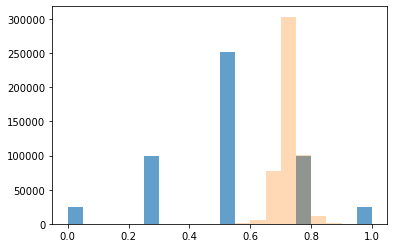

0.09502594400225152


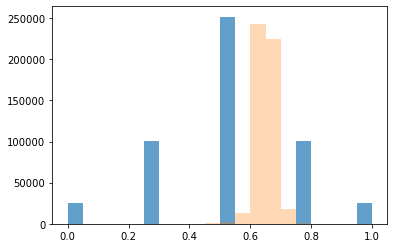

0.1686065202790482


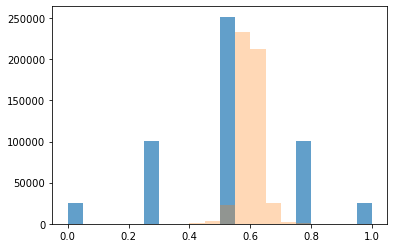

0.19917607819217548


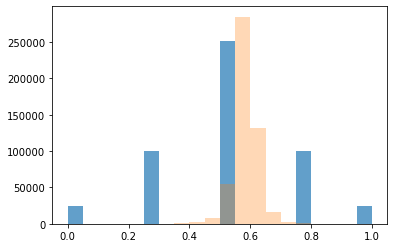

0.2039606150182485


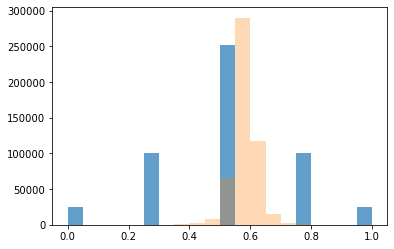

0.23928721655508908


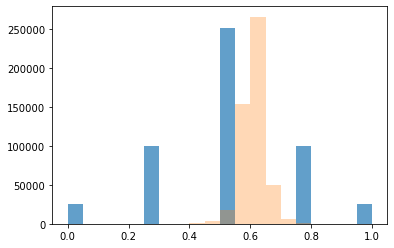

0.24617536050392624


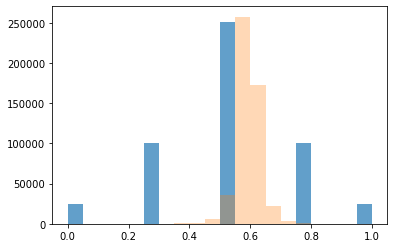

0.24748787462007893


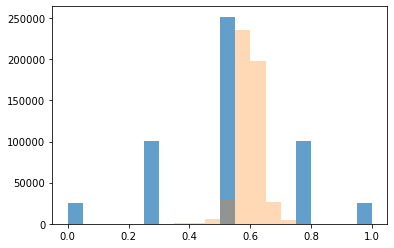

0.257610562840241


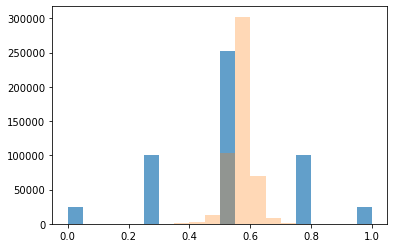

0.274158090380698


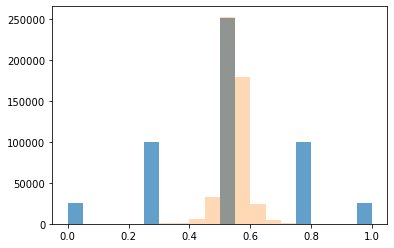

0.3059685060932019


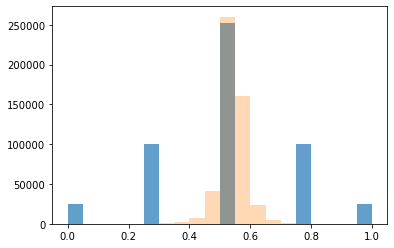

0.3074493730206335


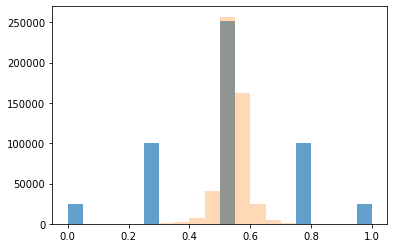

0.3082850250217737


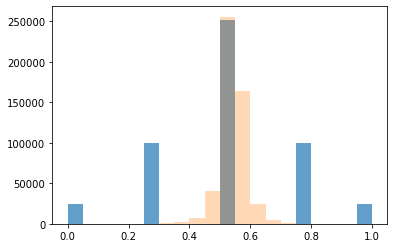

0.3089023740869498


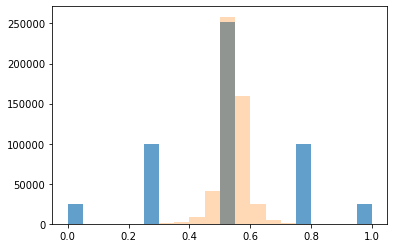

0.31411459159193467


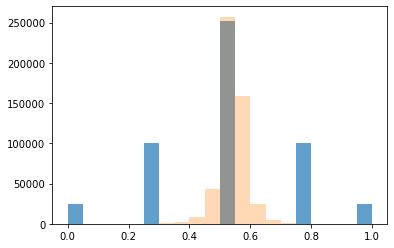

0.3149073250062172


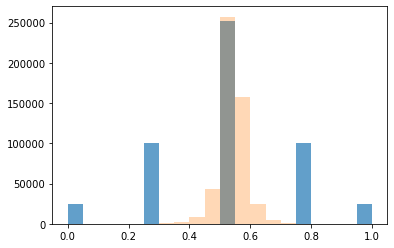

0.31883585520690216


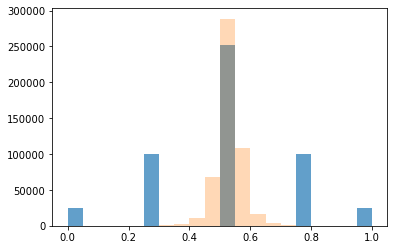

0.3294841190498376


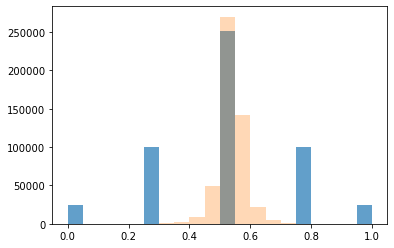

0.3478519613583651


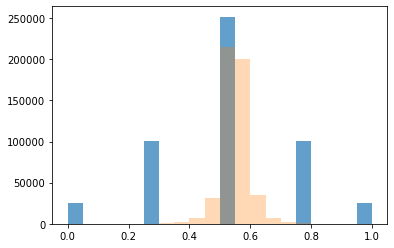

0.36622673437059916


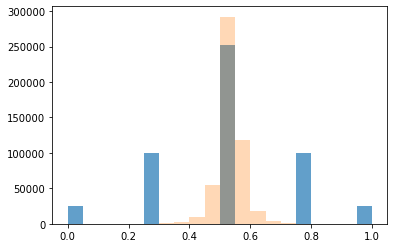

0.3674744399412492


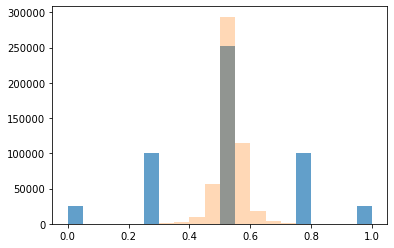

0.3686054995428019


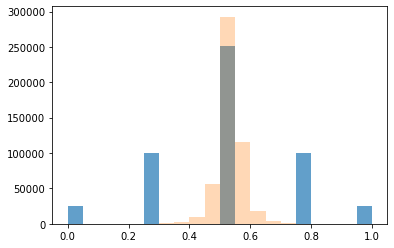

0.3702640756983167


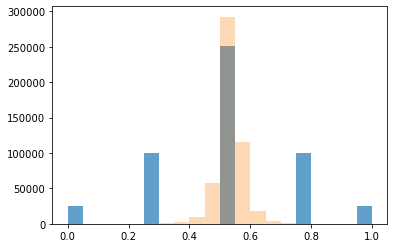

0.3757816855873834


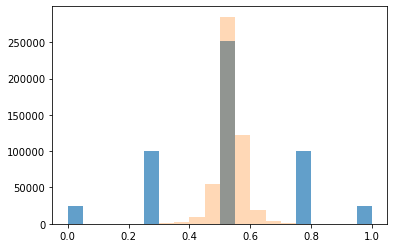

0.3788765350857614


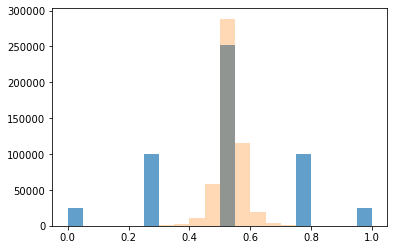

0.38380597462746546


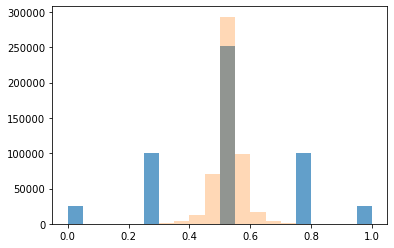

0.3874468671718807


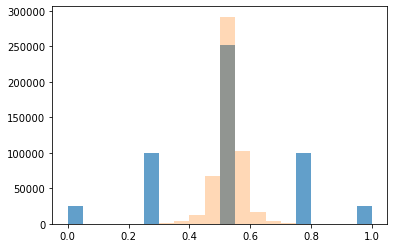

0.3894120306432159


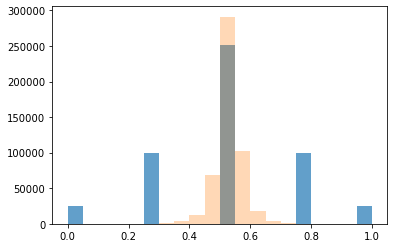

0.38994452729746915


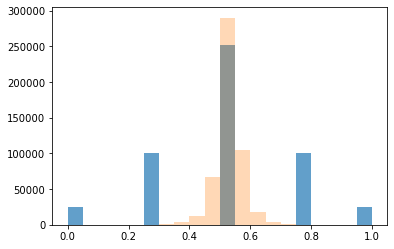

0.3914891888070069


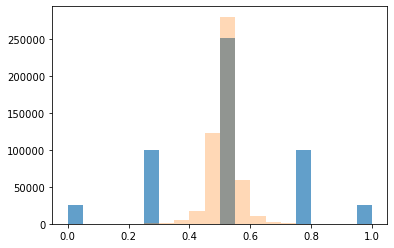

0.39413492335451566


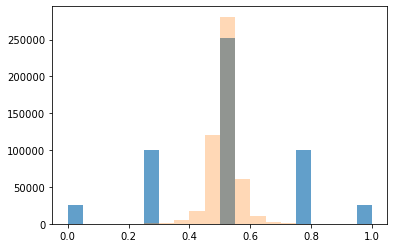

0.3962514540683278


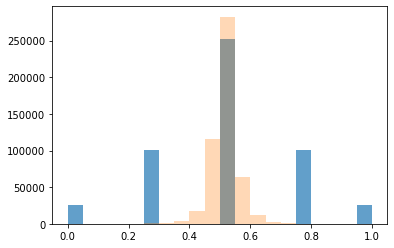

0.39895710242642146


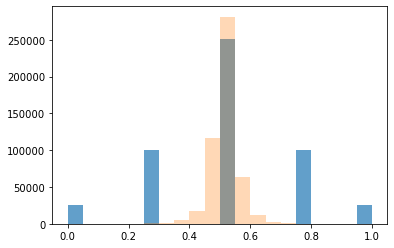

0.4065403905178068


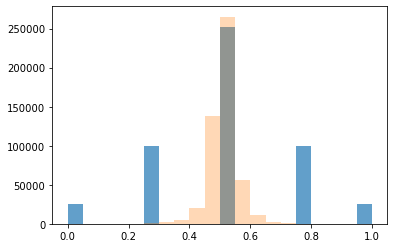

0.40701015607536767


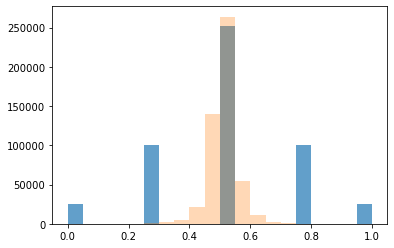

0.40846052507742153


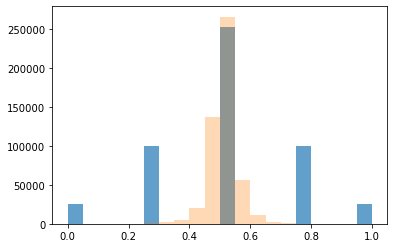

0.42863509952886936


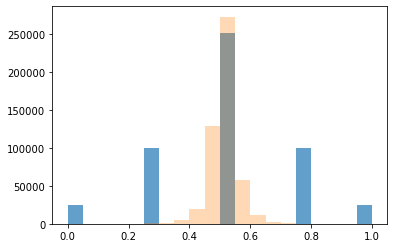

0.43654984482921283


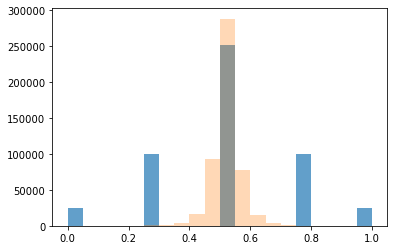

0.4407316361527545


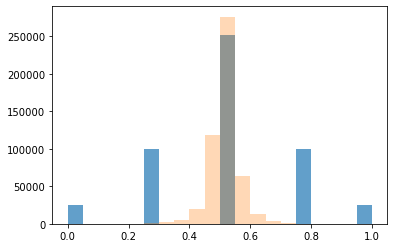

0.44154614492453675


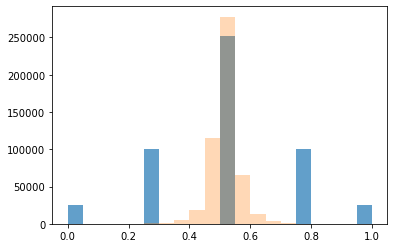

0.4430019082696443


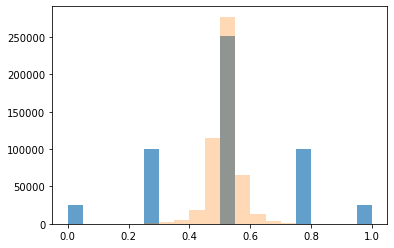

0.4434262364984882


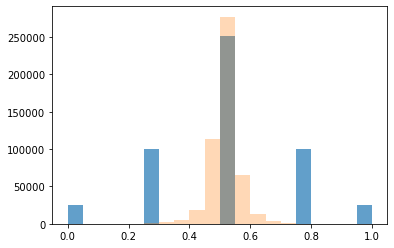

0.4456276940043881


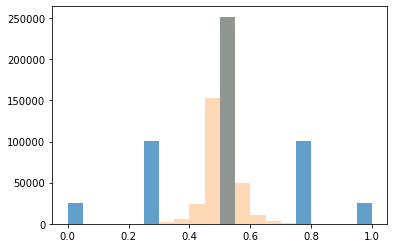

0.4523422132087347


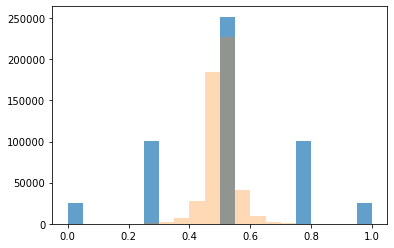

0.4579991589694799


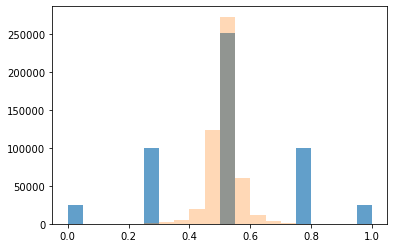

0.4595915975088694


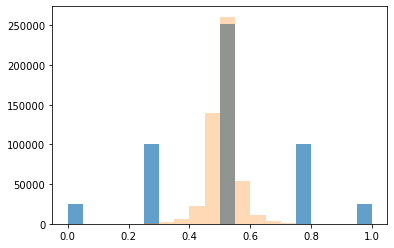

0.4598719648264375


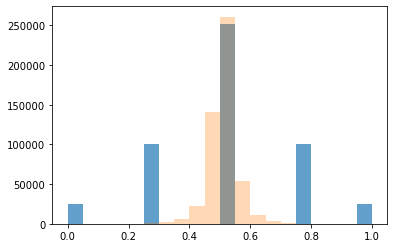

0.4663117866062041


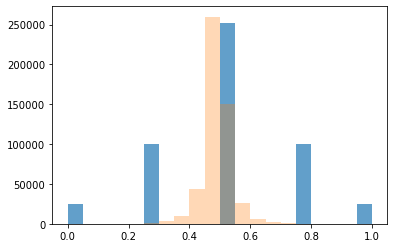

0.46909554336084597


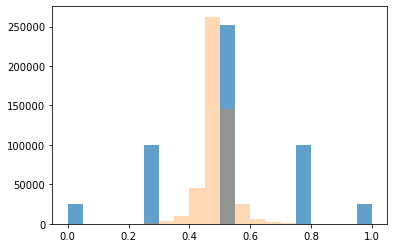

0.47412229857163946


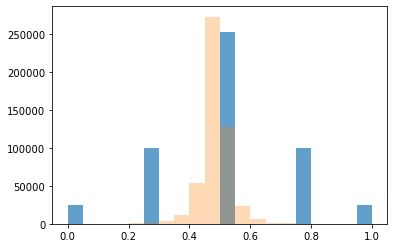

0.47515815087161306


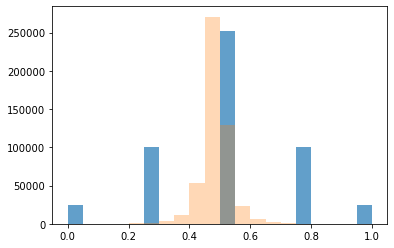

0.47728600061017634


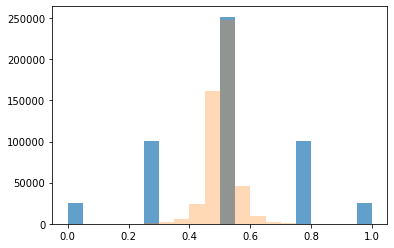

0.4789958712565088


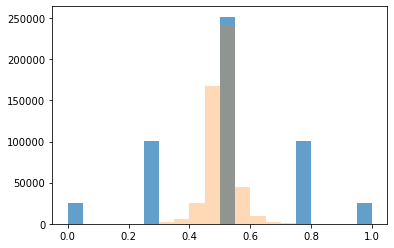

0.48132236873335826


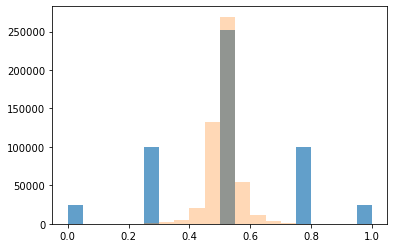

0.48790431781424276


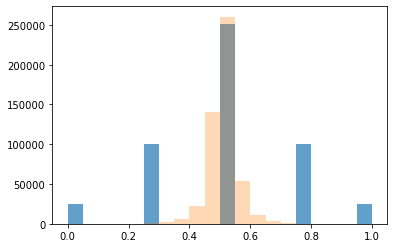

0.4897960980249078


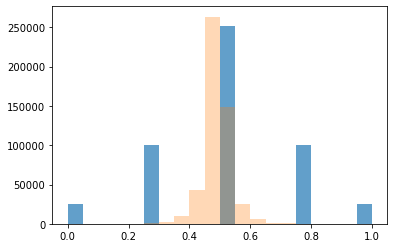

0.49415875691486366


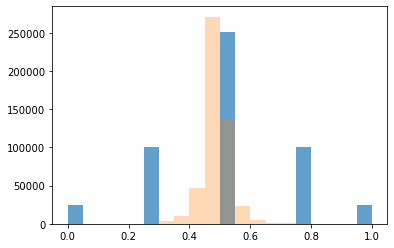

0.49554739442983353


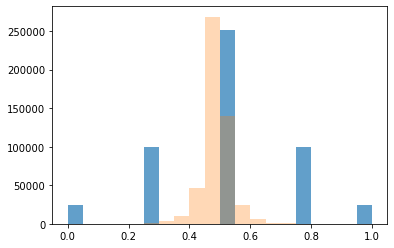

0.5008081708114186


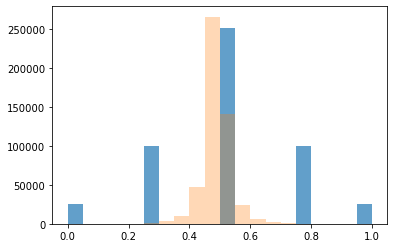

0.5039320432345739


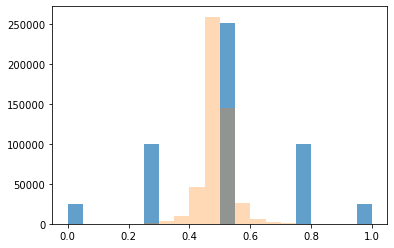

0.5042405843513291


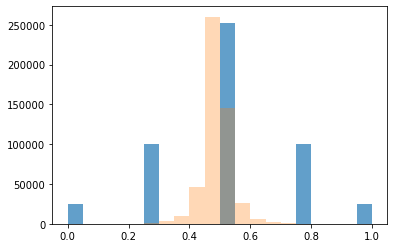

0.5045984292812281


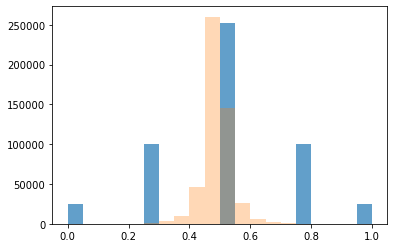

0.5139396371203936


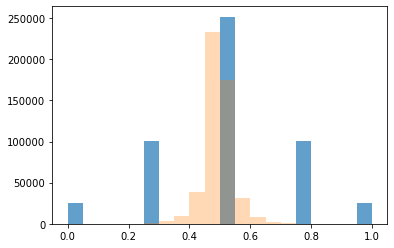

0.5205545887732183


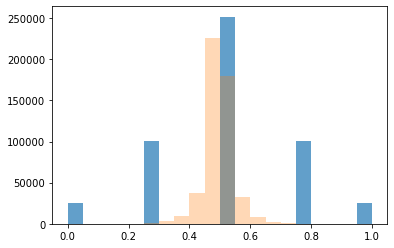

0.5208426656621155


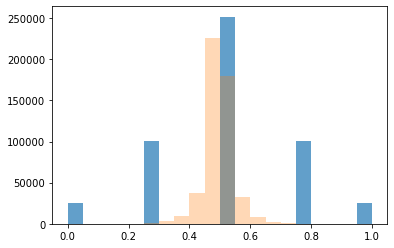

0.5223350563499088


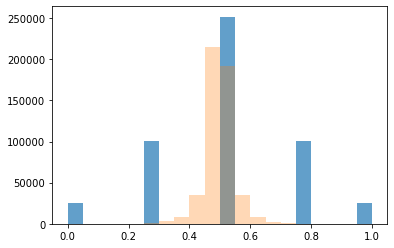

0.5228580344619881


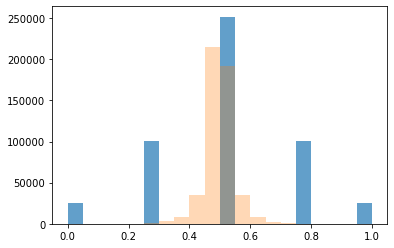

0.5242124588300962


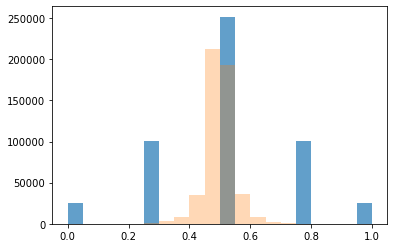

0.5289339793866081


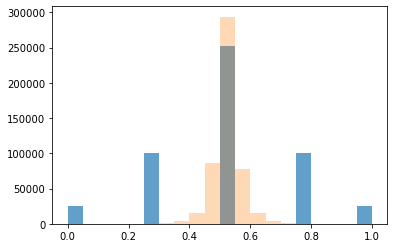

0.5313513348863694


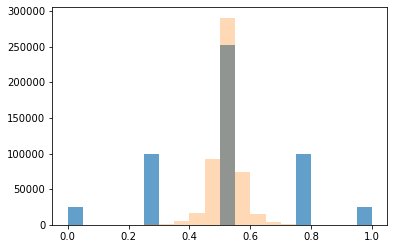

0.5334262777989868


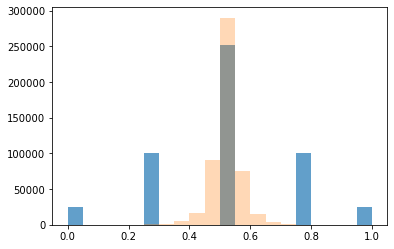

0.5344138323615581


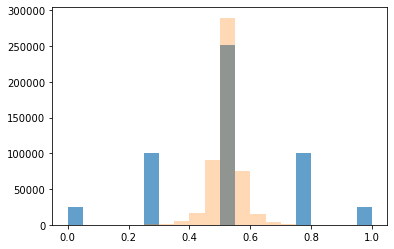

0.5384806327840709


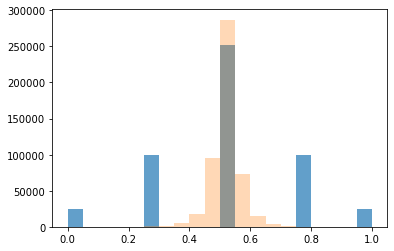

0.5448541849690032


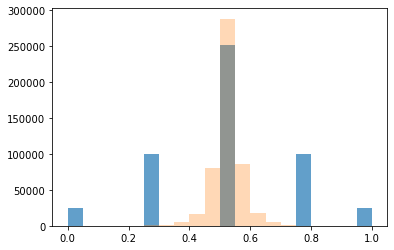

0.5453249878761564


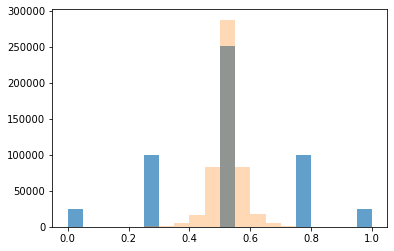

0.5488185910243523


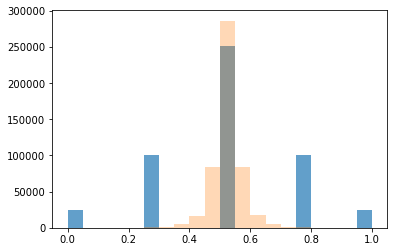

0.5500400312300867


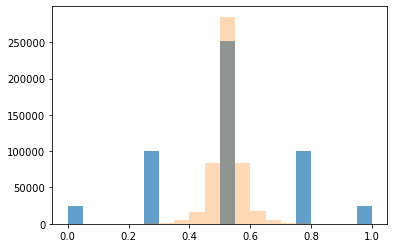

0.553121493714898


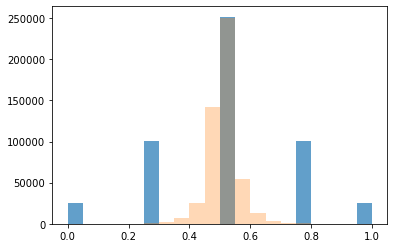

0.5541097026332001


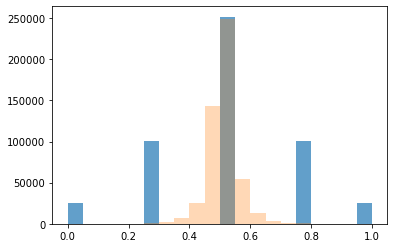

0.554491151998435


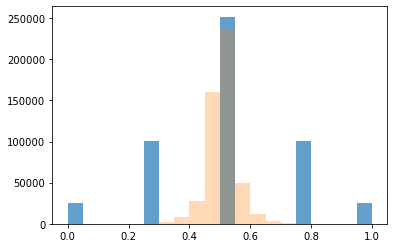

0.5570788789959902


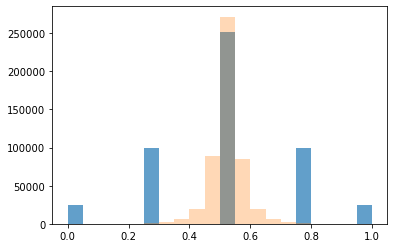

0.5604252220249624


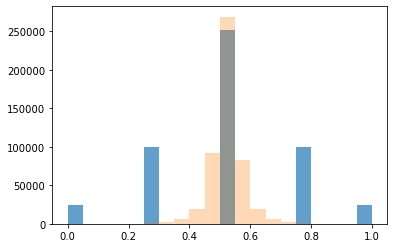

0.5647100539635185


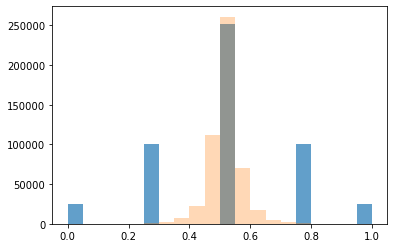

0.5654362658830533


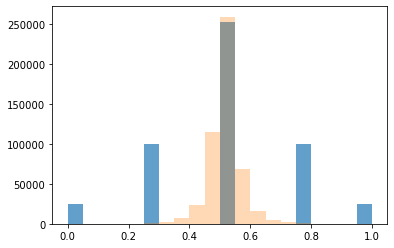

In [65]:
custom_loss_model = create_custom_loss_model()
hess_1 = create_score_summary(custom_loss_model)


In [31]:


print(hess_1)
print(f'{hess_2}')
print(f'{hess_2_5}')

{'correlation': 0.01648797232388479, 'corr_sharpe': 0.7010306197902315, 'corr_mean': 0.017032211259372695, 'corr_std': 0.0242959590901596, 'max_drawdown': -0.07007275835411342, 'feature_exposure': 0.0812378833825229, 'max_feature_exposure': 0.2435081750476723}
{'correlation': 0.021587338751162984, 'corr_sharpe': 0.8659976093901839, 'corr_mean': 0.02208136953559581, 'corr_std': 0.025498187634888526, 'max_drawdown': -0.058290826055683365, 'feature_exposure': 0.09436360629858727, 'max_feature_exposure': 0.26783214339177536}
{'correlation': 0.019092651809652767, 'corr_sharpe': 0.7343919978249995, 'corr_mean': 0.019649722663446976, 'corr_std': 0.02675644985463113, 'max_drawdown': -0.07112403174378734, 'feature_exposure': 0.09449682026876186, 'max_feature_exposure': 0.2762515202729946}


# Debugging

In [ ]:
def create_default_model():
  """
  Returns the model used for debugging. This is the point of compaison everything needs to beat.
  """
  default_params = {
                'n_estimators': 100,
                'objective': 'regression',
                'boosting_type': 'gbdt',
                'max_depth': 4,
                'learning_rate': .02,
                'feature_fraction': .25, 
                'seed': 3
                  }
  model = train_LGBMRegressor(params=default_params, train_data=TRAINING_DATA)
  return model

In [ ]:
default_model = create_default_model()
default_scores = create_score_summary(default_model)
default_scores
